# 1: Сортировка фото кошек и собак с помощью нейронной сети

Подгружаем нужные библиотеки

In [57]:
# Импорт библиотеки TensorFlow под псевдонимом tf
import tensorflow as tf  
# Импорт модуля ImageDataGenerator для аугментации изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
# Импорт класса Model для создания модели нейронной сети
from tensorflow.keras.models import Model  
# Импорт слоев для построения нейронной сети
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# Импорт предварительно обученной модели MobileNet и функции для предварительной 
# обработки входных данных  
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input  
# Импорт модуля для предварительной обработки изображений
from tensorflow.keras.preprocessing import image  
# Импорт модуля для математических операций
import math  
# Импорт библиотеки Matplotlib для визуализации данных
import matplotlib.pyplot as plt  
# Импорт библиотеки NumPy для работы с массивами
import numpy as np
# Импорт модуля Image из библиотеки Pillow для работы с изображениями  
from PIL import Image


**Скачиваем файлы:** https://disk.yandex.ru/d/OYYCfSzhfRcw8w \
Файлы уже отсортированы по папкам: \
– в папке ${\bf train}$ файлы для обучения нейросети \
– в папке ${\bf test}$ файлы для проверки нейросети \
Внутри этих папок есть папки ${\bf cats}$ и ${\bf dogs}$, где собрано несколько десятков фотографий с кошками и собаками. \
 \
${\bf Ответьте~на~вопрос:~для~чего~нужны~константы,~которые~вводятся~ниже?}$

In [58]:
TRAIN_DATA_DIR = '/Users/nikitamakarov/Documents/321/CatsDogs/train'  # Путь к каталогу с обучающими данными
VALIDATION_DATA_DIR = '/Users/nikitamakarov/Documents/321/CatsDogs/test'  # Путь к каталогу с данными для валидации
TRAIN_SAMPLES = 1000  # Общее количество обучающих примеров
VALIDATION_SAMPLES = 200  # Общее количество примеров для валидации
NUM_CLASSES = 2  # Количество классов (в данном случае два класса: 'кошки' и 'собаки')
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Размеры изображений (ширина и высота)
BATCH_SIZE = 5  # Размер пакета для обучения модели (количество образцов, обрабатываемых моделью за один шаг обучения)


Создаются два генератора данных. Для обучения нейросети недостаточно пары сотен фотографий. \
Поэтому будет использоваться такой приём как ${\bf аргументация}$ (что это?)

In [59]:
train_datagen = ImageDataGenerator(  # Создание генератора данных для обучения
    preprocessing_function=preprocess_input,  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
    rotation_range=20,  # Диапазон вращения изображений (от -20 до 20 градусов)
    width_shift_range=0.2,  # Диапазон сдвига изображений по горизонтали (относительно ширины изображения)
    height_shift_range=0.2,  # Диапазон сдвига изображений по вертикали (относительно высоты изображения)
    zoom_range=0.2  # Диапазон масштабирования изображений (от 0.8 до 1.2)
)

val_datagen = ImageDataGenerator(  # Создание генератора данных для валидации
    preprocessing_function=preprocess_input  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
)


In [60]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,  # Путь к каталогу с обучающими данными
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для обучения модели
    shuffle=True,  # Перемешивание данных после каждой эпохи
    seed=12345,  # Задание начального состояния для генератора случайных чисел (для воспроизводимости)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,  # Путь к каталогу с данными для валидации
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для валидации модели
    shuffle=False,  # Не перемешивать данные (для сохранения порядка)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)


Found 599 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


# Создание модели на основе нейронной сети, которая основана на готовой нейронной сети MobileNet (она называется базовой моделью). 
В базовой модели нужно отключить обучение (для всех слоев устанавливается **trainable = False**). \
Входное изображение поступает на вход базовой модели. \
После базовой модели добавляется несколько своих слоев: \
– слой пулинга **GlobalAveragePooling2D**; \
– полносвязный слой из **16 нейронов Dense**; \
– используется механизм Дропаут (случайное отключение нейронных связей во время обучения); \
– последний слой должен выдавать два значения (вероятности того, что на фото кошка или собака – два класса). \
Таким образом мы решаем задачу двухклассовой классификации.

In [61]:
def model_maker():
    # Создание базовой модели MobileNet без верхнего слоя классификации,
    # указывается форма входных данных (ширина, высота, количество каналов)
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Замораживаем веса всех слоев базовой модели, чтобы они не обучались
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    # Определение входного тензора модели
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Пропуск данных через базовую модель
    custom_model = base_model(input)
    
    # Глобальное пулингование для уменьшения размерности признаков
    custom_model = GlobalAveragePooling2D()(custom_model)
    
    # Полносвязный слой с 16 нейронами и функцией активации ReLU
    custom_model = Dense(32, activation='relu')(custom_model)
    
    # Слой регуляризации для предотвращения переобучения
    custom_model = Dropout(0.25)(custom_model)
    
    # Выходной слой с NUM_CLASSES нейронами и функцией активации softmax для многоклассовой классификации
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    # Создание модели с заданными входом и выходом
    return Model(inputs=input, outputs=predictions)


Компилируем и обучаем модель.

In [62]:
model = model_maker()  # Создание модели нейронной сети с помощью функции model_maker()

model.compile(loss='categorical_crossentropy',  # Функция потерь - категориальная перекрестная энтропия
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Оптимизатор - Adam с коэффициентом скорости обучения 0.001
              metrics=['acc'])  # Метрика для оценки производительности модели - точность классификации

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # Вычисление количества шагов обучения

history = model.fit(train_generator,  # Обучение модели на обучающих данных
                steps_per_epoch=num_steps,  # Количество шагов обучения
                epochs=50,  # Количество эпох обучения
                validation_data=validation_generator,  # Данные для валидации модели
                validation_steps=num_steps)  # Количество шагов валидации

Epoch 1/50
119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - acc: 0.7535 - loss: 0.5764

2024-05-22 12:49:38.302298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - acc: 0.7939 - loss: 0.4750 - val_acc: 0.9272 - val_loss: 0.1326
Epoch 2/50


2024-05-22 12:49:39.648433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9588 - loss: 0.1189

2024-05-22 12:49:46.413485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9579 - loss: 0.1218 - val_acc: 0.9404 - val_loss: 0.1206
Epoch 3/50


2024-05-22 12:49:47.564523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9642 - loss: 0.0961

2024-05-22 12:49:54.260570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9693 - loss: 0.0873 - val_acc: 0.9470 - val_loss: 0.1080
Epoch 4/50


2024-05-22 12:49:55.415816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9801 - loss: 0.0583

2024-05-22 12:50:02.194886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9747 - loss: 0.0642 - val_acc: 0.9669 - val_loss: 0.0566
Epoch 5/50


2024-05-22 12:50:03.367353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9843 - loss: 0.0677

2024-05-22 12:50:10.152667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9832 - loss: 0.0687 - val_acc: 0.9536 - val_loss: 0.1143
Epoch 6/50


2024-05-22 12:50:11.276321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9707 - loss: 0.0668

2024-05-22 12:50:18.057663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9690 - loss: 0.0717 - val_acc: 0.9603 - val_loss: 0.0845
Epoch 7/50


2024-05-22 12:50:19.150691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9850 - loss: 0.0450

2024-05-22 12:50:25.932306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9817 - loss: 0.0500 - val_acc: 0.9536 - val_loss: 0.1516
Epoch 8/50


2024-05-22 12:50:27.102284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9891 - loss: 0.0282

2024-05-22 12:50:33.922925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9841 - loss: 0.0382 - val_acc: 0.9404 - val_loss: 0.1797
Epoch 9/50


2024-05-22 12:50:35.047010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9758 - loss: 0.0652

2024-05-22 12:50:41.793978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9781 - loss: 0.0557 - val_acc: 0.9404 - val_loss: 0.2157
Epoch 10/50


2024-05-22 12:50:42.931804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9683 - loss: 0.0986

2024-05-22 12:50:49.698023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9670 - loss: 0.1021 - val_acc: 0.9603 - val_loss: 0.0681
Epoch 11/50


2024-05-22 12:50:50.833958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9727 - loss: 0.0733

2024-05-22 12:50:57.597037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9763 - loss: 0.0609 - val_acc: 0.9470 - val_loss: 0.1325
Epoch 12/50


2024-05-22 12:50:58.733982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9922 - loss: 0.0284

2024-05-22 12:51:05.495455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9927 - loss: 0.0269 - val_acc: 0.9470 - val_loss: 0.2116
Epoch 13/50


2024-05-22 12:51:06.609181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9889 - loss: 0.0177

2024-05-22 12:51:13.349074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9921 - loss: 0.0155 - val_acc: 0.9536 - val_loss: 0.0865
Epoch 14/50


2024-05-22 12:51:14.474728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9904 - loss: 0.0411

2024-05-22 12:51:21.238026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9909 - loss: 0.0346 - val_acc: 0.9536 - val_loss: 0.0827
Epoch 15/50


2024-05-22 12:51:22.358094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9861 - loss: 0.0368

2024-05-22 12:51:29.088688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9843 - loss: 0.0435 - val_acc: 0.9338 - val_loss: 0.3519
Epoch 16/50


2024-05-22 12:51:30.191834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9850 - loss: 0.0363

2024-05-22 12:51:36.985692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9877 - loss: 0.0311 - val_acc: 0.9603 - val_loss: 0.0766
Epoch 17/50


2024-05-22 12:51:38.075622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9892 - loss: 0.0216

2024-05-22 12:51:44.783291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9875 - loss: 0.0315 - val_acc: 0.9735 - val_loss: 0.0579
Epoch 18/50


2024-05-22 12:51:45.925739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9806 - loss: 0.0577

2024-05-22 12:51:52.720318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9830 - loss: 0.0552 - val_acc: 0.9536 - val_loss: 0.0842
Epoch 19/50


2024-05-22 12:51:53.838153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9872 - loss: 0.0402

2024-05-22 12:52:00.598519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9863 - loss: 0.0383 - val_acc: 0.9801 - val_loss: 0.0603
Epoch 20/50


2024-05-22 12:52:01.736143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9810 - loss: 0.0598

2024-05-22 12:52:08.556175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9819 - loss: 0.0517 - val_acc: 0.9603 - val_loss: 0.0561
Epoch 21/50


2024-05-22 12:52:09.706876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9903 - loss: 0.0222

2024-05-22 12:52:16.506181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9902 - loss: 0.0249 - val_acc: 0.9669 - val_loss: 0.1253
Epoch 22/50


2024-05-22 12:52:17.632192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9979 - loss: 0.0073

2024-05-22 12:52:24.400756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9967 - loss: 0.0104 - val_acc: 0.9470 - val_loss: 0.1891
Epoch 23/50


2024-05-22 12:52:25.519846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9963 - loss: 0.0122

2024-05-22 12:52:32.295409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9951 - loss: 0.0174 - val_acc: 0.9536 - val_loss: 0.1256
Epoch 24/50


2024-05-22 12:52:33.380099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9885 - loss: 0.0260

2024-05-22 12:52:40.163746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9897 - loss: 0.0255 - val_acc: 0.9603 - val_loss: 0.1115
Epoch 25/50


2024-05-22 12:52:41.273545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9940 - loss: 0.0305

2024-05-22 12:52:48.030732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9937 - loss: 0.0327 - val_acc: 0.9536 - val_loss: 0.1182
Epoch 26/50


2024-05-22 12:52:49.132457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9921 - loss: 0.0344

2024-05-22 12:52:55.951659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9899 - loss: 0.0387 - val_acc: 0.9470 - val_loss: 0.1732
Epoch 27/50


2024-05-22 12:52:57.107903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9858 - loss: 0.0223

2024-05-22 12:53:03.917700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9848 - loss: 0.0247 - val_acc: 0.9536 - val_loss: 0.0924
Epoch 28/50


2024-05-22 12:53:05.065514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9799 - loss: 0.0416

2024-05-22 12:53:11.842250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9812 - loss: 0.0427 - val_acc: 0.9536 - val_loss: 0.1201
Epoch 29/50


2024-05-22 12:53:12.978900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9905 - loss: 0.0199

2024-05-22 12:53:19.761731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9889 - loss: 0.0209 - val_acc: 0.9536 - val_loss: 0.1224
Epoch 30/50


2024-05-22 12:53:20.901652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9828 - loss: 0.0492

2024-05-22 12:53:27.677422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9837 - loss: 0.0461 - val_acc: 0.9603 - val_loss: 0.1251
Epoch 31/50


2024-05-22 12:53:28.816353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9953 - loss: 0.0145

2024-05-22 12:53:35.598051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9938 - loss: 0.0180 - val_acc: 0.9404 - val_loss: 0.2395
Epoch 32/50


2024-05-22 12:53:36.718235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9861 - loss: 0.0314

2024-05-22 12:53:43.502443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9877 - loss: 0.0301 - val_acc: 0.9536 - val_loss: 0.1359
Epoch 33/50


2024-05-22 12:53:44.637673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9981 - loss: 0.0166

2024-05-22 12:53:51.410845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9975 - loss: 0.0173 - val_acc: 0.9470 - val_loss: 0.2396
Epoch 34/50


2024-05-22 12:53:52.584755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9812 - loss: 0.0249

2024-05-22 12:53:59.379105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9841 - loss: 0.0232 - val_acc: 0.9536 - val_loss: 0.1061
Epoch 35/50


2024-05-22 12:54:00.458207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9824 - loss: 0.0334

2024-05-22 12:54:07.267224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9855 - loss: 0.0285 - val_acc: 0.9536 - val_loss: 0.1838
Epoch 36/50


2024-05-22 12:54:08.385514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9972 - loss: 0.0267

2024-05-22 12:54:15.138777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9949 - loss: 0.0315 - val_acc: 0.9272 - val_loss: 0.2797
Epoch 37/50


2024-05-22 12:54:16.217410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9968 - loss: 0.0085

2024-05-22 12:54:22.985055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9974 - loss: 0.0083 - val_acc: 0.9536 - val_loss: 0.1219
Epoch 38/50


2024-05-22 12:54:24.105718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9978 - loss: 0.0124

2024-05-22 12:54:30.932325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9960 - loss: 0.0224 - val_acc: 0.9603 - val_loss: 0.0994
Epoch 39/50


2024-05-22 12:54:32.115639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9962 - loss: 0.0185

2024-05-22 12:54:38.955163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9964 - loss: 0.0175 - val_acc: 0.9536 - val_loss: 0.1875
Epoch 40/50


2024-05-22 12:54:40.127874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9909 - loss: 0.0156

2024-05-22 12:54:46.932975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9925 - loss: 0.0137 - val_acc: 0.9338 - val_loss: 0.2354
Epoch 41/50


2024-05-22 12:54:48.104483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9816 - loss: 0.0307

2024-05-22 12:54:54.917842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9816 - loss: 0.0350 - val_acc: 0.9735 - val_loss: 0.0617
Epoch 42/50


2024-05-22 12:54:56.085079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 1.0000 - loss: 0.0037

2024-05-22 12:55:02.941501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9993 - loss: 0.0061 - val_acc: 0.9735 - val_loss: 0.0881
Epoch 43/50


2024-05-22 12:55:04.129669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9838 - loss: 0.0616

2024-05-22 12:55:10.924989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9843 - loss: 0.0569 - val_acc: 0.9536 - val_loss: 0.1548
Epoch 44/50


2024-05-22 12:55:12.061228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9686 - loss: 0.0613

2024-05-22 12:55:18.833150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9739 - loss: 0.0518 - val_acc: 0.9404 - val_loss: 0.1980
Epoch 45/50


2024-05-22 12:55:19.993083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9975 - loss: 0.0123

2024-05-22 12:55:26.815296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9971 - loss: 0.0131 - val_acc: 0.9536 - val_loss: 0.1797
Epoch 46/50


2024-05-22 12:55:27.980197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9908 - loss: 0.0235

2024-05-22 12:55:34.790193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9911 - loss: 0.0241 - val_acc: 0.9669 - val_loss: 0.0728
Epoch 47/50


2024-05-22 12:55:35.961870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9948 - loss: 0.0228

2024-05-22 12:55:42.751666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9942 - loss: 0.0243 - val_acc: 0.9669 - val_loss: 0.0935
Epoch 48/50


2024-05-22 12:55:43.896555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9862 - loss: 0.0312

2024-05-22 12:55:50.678934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9850 - loss: 0.0369 - val_acc: 0.9536 - val_loss: 0.1415
Epoch 49/50


2024-05-22 12:55:51.819710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9904 - loss: 0.0341

2024-05-22 12:55:58.653933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9909 - loss: 0.0321 - val_acc: 0.9669 - val_loss: 0.1118
Epoch 50/50


2024-05-22 12:55:59.820766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - acc: 0.9993 - loss: 0.0078

2024-05-22 12:56:06.730703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - acc: 0.9989 - loss: 0.0092 - val_acc: 0.9735 - val_loss: 0.0883


2024-05-22 12:56:07.910150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Построим график.

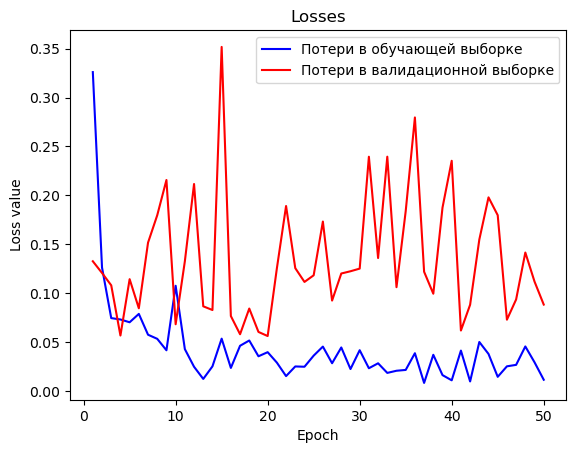

In [63]:
loss_function = history.history['loss']  # Получение значений функции потерь на обучающем наборе данных из истории обучения
val_loss_function = history.history['val_loss']  # Получение значений функции потерь на валидационном наборе данных из истории обучения
epochs = range(1, len(loss_function) + 1)  # Создание списка эпох для оси x

plt.title('Losses')  # Заголовок графика
plt.plot(epochs, loss_function, color='blue', label='Потери в обучающей выборке')  # График функции потерь на обучающем наборе
plt.plot(epochs, val_loss_function, color='red', label='Потери в валидационной выборке')  # График функции потерь на валидационном наборе
plt.xlabel('Epoch')  # Подпись оси x
plt.ylabel('Loss value')  # Подпись оси y
plt.legend()  # Добавление легенды
plt.show()  # Отображение графика




Визуализация функции потерь позволяет оценить эффективность обучения модели: мы стремимся к тому, чтобы функция потерь на обучающем и валидационном наборах данных уменьшалась с каждой эпохой, что свидетельствует о том, что модель обучается эффективно и не переобучается. \
Теперь модель можно использовать и проверить, как она работает.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


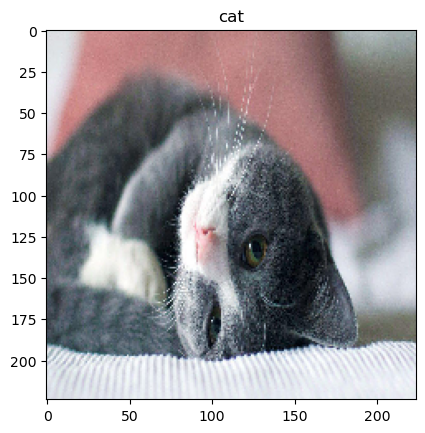

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


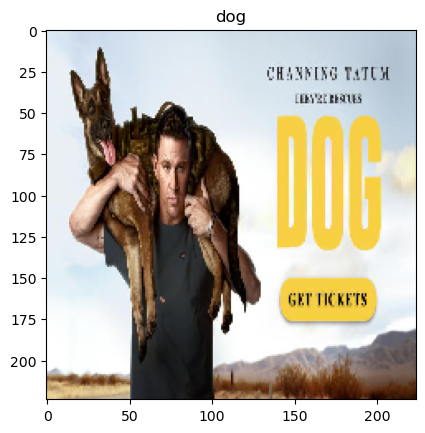

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


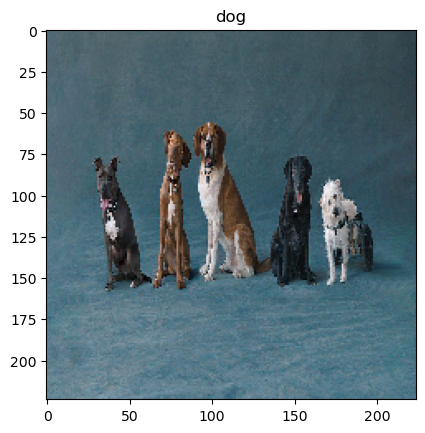

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


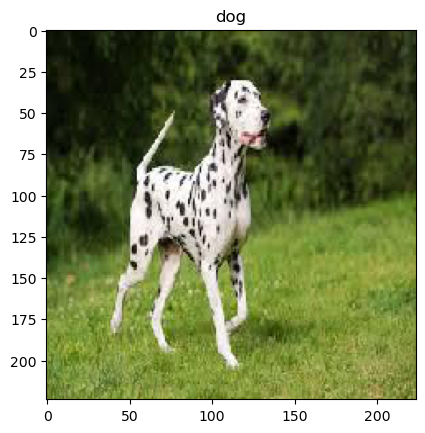

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


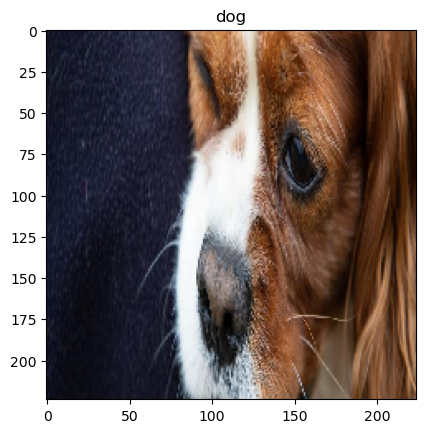

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


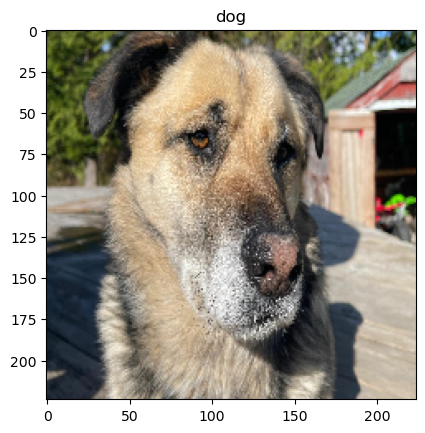

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


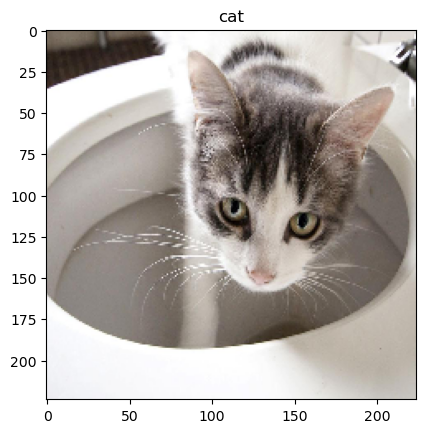

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


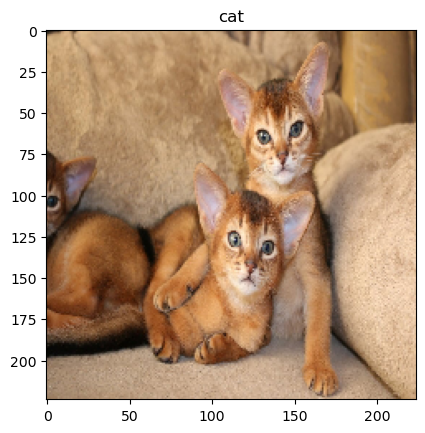

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


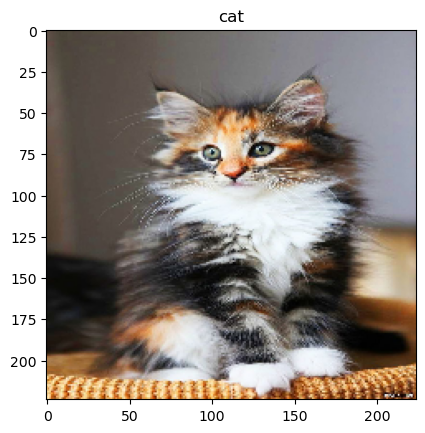

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


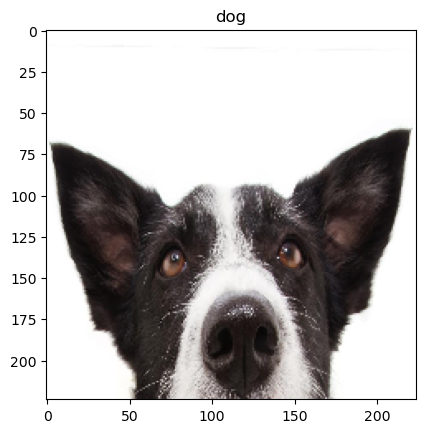

In [64]:
import os  # Импорт модуля os для работы с файловой системой
import random  # Импорт модуля random для работы с случайными числами

categ = ['cat', 'dog']  # Список категорий: 'cat' - кошка, 'dog' - собака
files = []  # Пустой список для хранения путей к изображениям

# Перебор всех файлов в каталоге с кошками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/nikitamakarov/Documents/321/CatsDogs/test/cats'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Перебор всех файлов в каталоге с собаками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/nikitamakarov/Documents/321/CatsDogs/test/dogs'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Выбор случайных 10 изображений из списка files и их отображение с предсказанием модели
for f in random.sample(files, 10):
    img_path = f  # Путь к изображению
    img = image.load_img(img_path, target_size=(224,224))  # Загрузка изображения с изменением размера до 224x224 пикселя
    img_array = image.img_to_array(img)  # Преобразование изображения в массив numpy

    expanded_img_array = np.expand_dims(img_array, axis=0)  # Расширение массива изображения
    preprocessed_img = preprocess_input(expanded_img_array)  # Предварительная обработка изображения
    prediction = model.predict(preprocessed_img)  # Получение предсказания от модели
    
    plt.title(categ[np.argmax(prediction)])  # Установка заголовка графика в соответствии с предсказанием модели
    plt.imshow(img)  # Отображение изображения
    plt.show()  # Показ графика
